## Implocit ratings and item based filtering 
## 基於物品的過濾算法

目前為止我們描述的都是基於「用戶」的協同過濾算法，「協同過濾」來進行推薦，使用的是「用戶產生」的各種數據，因此又稱為社會化過濾算法。比如你購買了Phoenix專輯，我們藉其他購買過這張專輯的用戶還會購買Vampire的專輯，因此會把它推薦給你；或是我在Netflix上觀看了Doctor，網站會向我推薦Quantum Leap，計算出兩件物品之間的相似度，比如Phoenix專輯和Manners很相似。如果一個用戶給Phoenix打了很高的分數，我們就可以向他推薦Manners了。

### 顯式評價 

用戶的評價類型可以分為顯式評價和隱式評價。顯式評價指的是用戶明確地給出對物品的評 價，像是 YouTube 上的 Like 和 Dislike

### 隱式評價 

我們不讓用戶明確給出對物品的評價，而是通過觀察他們的行為來獲得偏好信息。記錄用戶在紐約時報網上的點擊記錄。經過幾週的觀察之後，我們就可以為用戶刻畫出一個合理的模型了——她不喜歡體育新聞， 但關注科技新聞；如果用戶連續看了兩篇文章：《快速減肥方法》和《不反彈的減肥方式》，那她很可能正在減肥；如果她點擊了iPhone的廣告，就表明她或許對這款產品感興趣。

### 常見問題
- 問題1：人們很懶，不願評價物品
- 問題2：人們會撒謊，或存有偏見
- 問題3：人們不會更新他們的評論

## Adjusted Cosine Similarity (修正餘弦相似度)

Badrul Sarwar, George Karypis, Joseph Konstan, and John Riedl
http://files.grouplens.org/papers/www10_sarwar.pdf

我們使用餘弦相似度來計算兩個物品的距離。我們會從用戶的評價中減去他所有評價的均值，這就是修正的餘弦相似度。 公式 U 表示同時評價過物品 i 和 j 的用戶集合

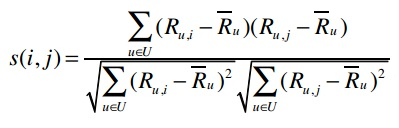

In [8]:
from math import sqrt

users3 = {"David": {"Imagine Dragons": 3, "Daft Punk": 5,
                    "Lorde": 4, "Fall Out Boy": 1},
          "Matt":  {"Imagine Dragons": 3, "Daft Punk": 4,
                    "Lorde": 4, "Fall Out Boy": 1},
          "Ben":   {"Kacey Musgraves": 4, "Imagine Dragons": 3,
                    "Lorde": 3, "Fall Out Boy": 1},
          "Chris": {"Kacey Musgraves": 4, "Imagine Dragons": 4,
                    "Daft Punk": 4, "Lorde": 3, "Fall Out Boy": 1},
          "Tori":  {"Kacey Musgraves": 5, "Imagine Dragons": 4,
                    "Daft Punk": 5, "Fall Out Boy": 3}}


In [9]:
def computeSimilarity(band1, band2, userRatings):
    averages = {}
    for (key, ratings) in userRatings.items():
        averages[key] = (float(sum(ratings.values()))
                         / len(ratings.values()))

    num = 0  # numerator
    dem1 = 0 # first half of denominator
    dem2 = 0
    for (user, ratings) in userRatings.items():
        if band1 in ratings and band2 in ratings:
            avg = averages[user]
            num += (ratings[band1] - avg) * (ratings[band2] - avg)
            dem1 += (ratings[band1] - avg)**2
            dem2 += (ratings[band2] - avg)**2
    return num / (sqrt(dem1) * sqrt(dem2))

print(computeSimilarity('Kacey Musgraves', 'Lorde', users3)) 
print(computeSimilarity('Imagine Dragons', 'Lorde', users3)) 
print(computeSimilarity('Daft Punk', 'Lorde', users3))

0.320959291340884
-0.2525265372291518
0.7841149584671063


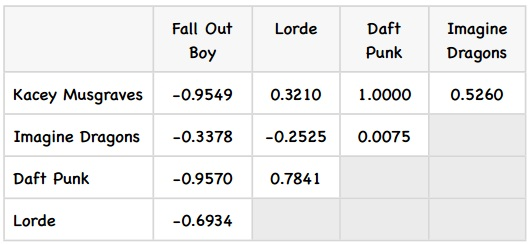

如何使用這個矩陣來做預測呢？比如我想知道 David 有多喜歡 Kacey Musgraves？ 
- 為了讓公式的計算效果更佳，對物品的評價分值最好介於-1和1之間。
- 由於我們的評分系統是1至5星，所以需要將其轉換到-1至1之間。

- p(u,i) 表示我們會來預測「用戶u」對「物品i」的評分
- p(David, Kacey) 就表示 David 會給 Kacey 打多少分
- (Si,N) 表示物品 (i,N) 的相似度，
- (Ru,n) 表示用戶 (u) 對物品 (N) 的評分。

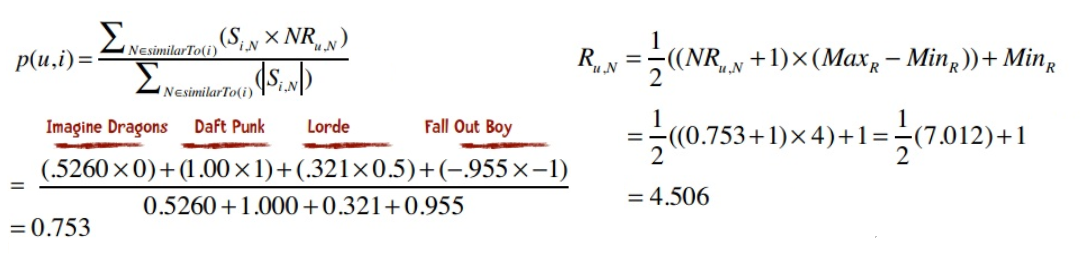

## Slope One 協同過濾法 & 加權 Slope One

Lemire, Machlachlan
http://www.daniel-lemire.com/fr/abstracts/SDM2005.html

- 最大的優勢是簡單易於實現。
- 假設 Amy 給 PSY 打了3分，給 Whitney Houston 打了4分；
- 那麼 Ben 給 PSY 打了4分。會給 Whitney Houston 打幾分? 
- 我們預測Ben也會給高一分，即給到5分。


Spotify 有 100 萬個用戶對 20 萬個歌手做評價。如果有一個新進的用戶對 10 個歌手 做了評價，是否需要重新計算20萬×20萬的差異數據? 不需要正是Slope One的美妙之處。

對於兩個物品，我們只需記錄同時評價過這對物品的用戶數就可以了。比如說Taylor Swift和PSY的差值是2，是根據9位用戶的評價計算的。當有一個新用戶對Taylor Swift打了5分，PSY打了1分時，更新後的差值為：((9*2)+4) / 10 = 2.2

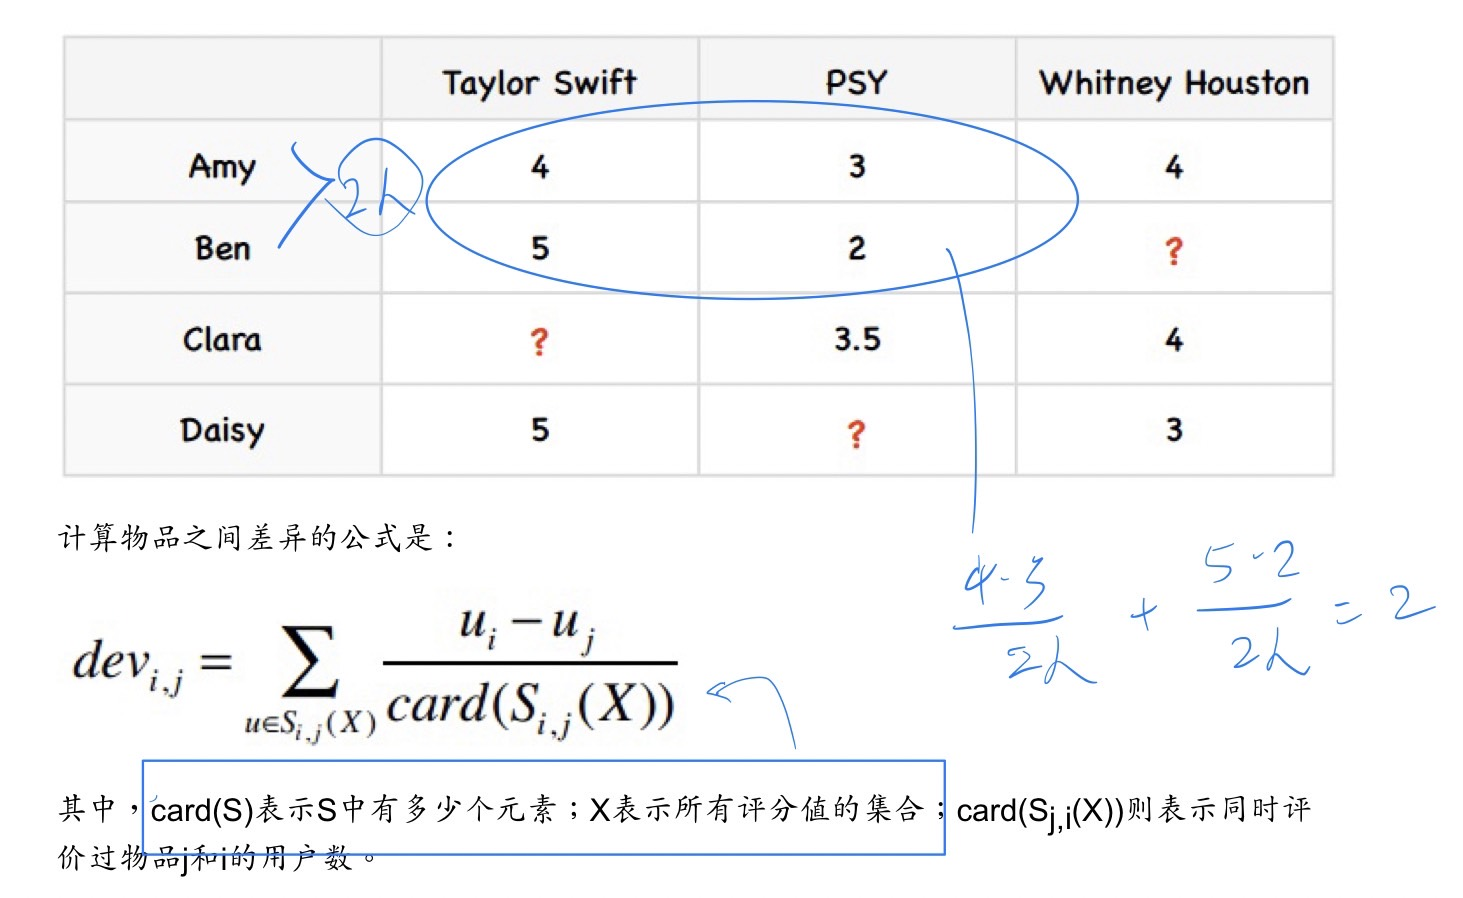

In [64]:
users2 = {"Amy": {"Taylor Swift": 4, "PSY": 3, "Whitney Houston": 4},
          "Ben": {"Taylor Swift": 5, "PSY": 2},
          "Clara": {"PSY": 3.5, "Whitney Houston": 4},
          "Daisy": {"Taylor Swift": 5, "Whitney Houston": 3}}

In [71]:
class recommender:
    def __init__(self, data, k=1, metric='pearson', n=5):
        self.k = k
        self.n = n
        self.username2id = {}
        self.userid2name = {}
        self.productid2name = {}
        self.frequencies = {}
        self.deviations = {}
        self.metric = metric
        if type(data).__name__ == 'dict':
            self.data = data
        
    def computeDeviations(self):
    # 每個人的評分數據
        for ratings in self.data.values():

            # 初始化該用戶的每個評分項目
            for (item, rating) in ratings.items():
                self.frequencies.setdefault(item, {})
                self.deviations.setdefault(item, {})    
                for (item2, rating2) in ratings.items():

                    #保存至變量中
                    if item != item2:
                        self.frequencies[item].setdefault(item2, 0)
                        self.deviations[item].setdefault(item2, 0.0)
                        self.frequencies[item][item2] += 1
                        self.deviations[item][item2] += rating - rating2
        #計算差異值
        for (item, ratings) in self.deviations.items():
            for item2 in ratings:
                ratings[item2] /= self.frequencies[item][item2]
    
    ##--------------- 加權 Slope One 算法 ----------
    def slopeOneRecommendations(self, userRatings):
        recommendations = {}
        frequencies = {}
        # 每個人的評分數據
        for (userItem, userRating) in userRatings.items():
            # 用戶未評分的歌手
            for (diffItem, diffRatings) in self.deviations.items():
                if diffItem not in userRatings and userItem in self.deviations[diffItem]:
                    freq = self.frequencies[diffItem][userItem]
                    recommendations.setdefault(diffItem, 0.0)
                    frequencies.setdefault(diffItem, 0)
                    
                    recommendations[diffItem] += (diffRatings[userItem] + userRating) * freq #分子
                    frequencies[diffItem] += freq # 分母
        
        recommendations =  [(self.convertProductID2name(k),v / frequencies[k]) for (k, v) in recommendations.items()]
        recommendations.sort(key=lambda artistTuple: artistTuple[1],reverse = True)
        
        # return the first 50 recommendations
        return recommendations[:50]
    
    def convertProductID2name(self, id):
        if id in self.productid2name:
            return self.productid2name[id]
        else:
            return id
    

In [72]:
r = recommender(users2)
r.computeDeviations()
r.deviations

{'Taylor Swift': {'PSY': 2.0, 'Whitney Houston': 1.0},
 'PSY': {'Taylor Swift': -2.0, 'Whitney Houston': -0.75},
 'Whitney Houston': {'Taylor Swift': -1.0, 'PSY': 0.75}}

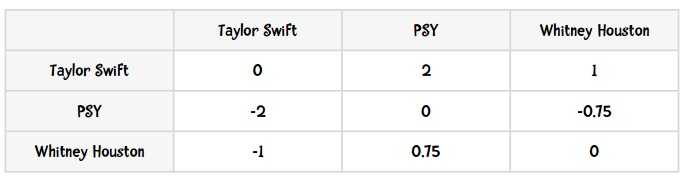

## Example code

In [9]:
import codecs 
from math import sqrt

users2 = {"Amy": {"Taylor Swift": 4, "PSY": 3, "Whitney Houston": 4},
          "Ben": {"Taylor Swift": 5, "PSY": 2},
          "Clara": {"PSY": 3.5, "Whitney Houston": 4},
          "Daisy": {"Taylor Swift": 5, "Whitney Houston": 3}}

users = {"Angelica": {"Blues Traveler": 3.5, "Broken Bells": 2.0,
                      "Norah Jones": 4.5, "Phoenix": 5.0,
                      "Slightly Stoopid": 1.5, "The Strokes": 2.5,
                      "Vampire Weekend": 2.0},
         "Bill":{"Blues Traveler": 2.0, "Broken Bells": 3.5,
                 "Deadmau5": 4.0, "Phoenix": 2.0,
                 "Slightly Stoopid": 3.5, "Vampire Weekend": 3.0},
         "Chan": {"Blues Traveler": 5.0, "Broken Bells": 1.0,
                  "Deadmau5": 1.0, "Norah Jones": 3.0,
                  "Phoenix": 5, "Slightly Stoopid": 1.0},
         "Dan": {"Blues Traveler": 3.0, "Broken Bells": 4.0,
                 "Deadmau5": 4.5, "Phoenix": 3.0,
                 "Slightly Stoopid": 4.5, "The Strokes": 4.0,
                 "Vampire Weekend": 2.0},
         "Hailey": {"Broken Bells": 4.0, "Deadmau5": 1.0,
                    "Norah Jones": 4.0, "The Strokes": 4.0,
                    "Vampire Weekend": 1.0},
         "Jordyn":  {"Broken Bells": 4.5, "Deadmau5": 4.0,
                     "Norah Jones": 5.0, "Phoenix": 5.0,
                     "Slightly Stoopid": 4.5, "The Strokes": 4.0,
                     "Vampire Weekend": 4.0},
         "Sam": {"Blues Traveler": 5.0, "Broken Bells": 2.0,
                 "Norah Jones": 3.0, "Phoenix": 5.0,
                 "Slightly Stoopid": 4.0, "The Strokes": 5.0},
         "Veronica": {"Blues Traveler": 3.0, "Norah Jones": 5.0,
                      "Phoenix": 4.0, "Slightly Stoopid": 2.5,
                      "The Strokes": 3.0}
        }


class recommender:
    def __init__(self, data, k=1, metric='pearson', n=5):
        self.k = k
        self.n = n
        self.username2id = {}
        self.userid2name = {}
        self.productid2name = {}
        self.frequencies = {}
        self.deviations = {}
        self.metric = metric
        if self.metric == 'pearson':
            self.fn = self.pearson
        if type(data).__name__ == 'dict':
            self.data = data
    
    def convertProductID2name(self, id):
        if id in self.productid2name:
            return self.productid2name[id]
        else:
            return id
    
    def userRatings(self, id, n):
        print ("Ratings for " + self.userid2name[id])
        ratings = self.data[id]
        print(len(ratings))
        ratings = list(ratings.items())[:n]
        ratings = [(self.convertProductID2name(k), v) for (k, v) in ratings]
        # finally sort and return
        ratings.sort(key=lambda artistTuple: artistTuple[1],reverse = True)      
        for rating in ratings:
            print("%s\t%i" % (rating[0], rating[1]))
    
    def showUserTopItems(self, user, n):
        items = list(self.data[user].items())
        items.sort(key=lambda itemTuple: itemTuple[1], reverse=True)
        for i in range(n):
            print("%s\t%i" % (self.convertProductID2name(items[i][0]),items[i][1]))
    
    def loadMovieLens(self, path=''):
        self.data = {}
        i = 0
        #f = codecs.open(path + "u.data", 'r', 'utf8')
        f = codecs.open(path + "u.data", 'r', 'ascii')
        #  f = open(path + "u.data")
        for line in f:
            i += 1
            #separate line into fields
            fields = line.split('\t')
            user = fields[0]
            movie = fields[1]
            rating = int(fields[2].strip().strip('"'))
            if user in self.data:
                currentRatings = self.data[user]
            else:
                currentRatings = {}
        currentRatings[movie] = rating
        self.data[user] = currentRatings
        f.close()
        
        #f = codecs.open(path + "u.item", 'r', 'utf8')
        f = codecs.open(path + "u.item", 'r', 'iso8859-1', 'ignore')
        #f = open(path + "u.item")
        for line in f:
            i += 1
            fields = line.split('|')
            mid = fields[0].strip()
            title = fields[1].strip()
            self.productid2name[mid] = title
        f.close()
        
        #f = codecs.open(path + "u.user", 'r', 'utf8')
        f = open(path + "u.user")
        for line in f:
            i += 1
            fields = line.split('|')
            userid = fields[0].strip('"')
            self.userid2name[userid] = line
            self.username2id[line] = userid
        f.close()
        print(i)
        
    def loadBookDB(self, path=''):
        self.data = {}
        i = 0
        
        f = codecs.open(path + "u.data", 'r', 'utf8')
        for line in f:
            i += 1
            fields = line.split(';')
            user = fields[0].strip('"')
            book = fields[1].strip('"')
            rating = int(fields[2].strip().strip('"'))
        if rating > 5:
            print("EXCEEDING ", rating)
        if user in self.data:
            currentRatings = self.data[user]
        else:
            currentRatings = {}
        currentRatings[book] = rating
        self.data[user] = currentRatings
        f.close()
        
        f = codecs.open(path + "BX-Books.csv", 'r', 'utf8')
        for line in f:
            i += 1
            fields = line.split(';')
            isbn = fields[0].strip('"')
            title = fields[1].strip('"')
            author = fields[2].strip().strip('"')
            title = title + ' by ' + author
            self.productid2name[isbn] = title
        f.close()
        
        f = codecs.open(path + "BX-Users.csv", 'r', 'utf8')
        for line in f:
            i += 1
            fields = line.split(';')
            userid = fields[0].strip('"')
            location = fields[1].strip('"')
        if len(fields) > 3:
            age = fields[2].strip().strip('"')
        else:
            age = 'NULL'
        if age != 'NULL':
            value = location + '  (age: ' + age + ')'
        else:
            value = location
        self.userid2name[userid] = value
        self.username2id[location] = userid
        f.close()
        print(i)
    
    def computeDeviations(self):
        for ratings in self.data.values():
            for (item, rating) in ratings.items():
                self.frequencies.setdefault(item, {})
                self.deviations.setdefault(item, {})                    
            for (item2, rating2) in ratings.items():
                if item != item2:
                    self.frequencies[item].setdefault(item2, 0)
                    self.deviations[item].setdefault(item2, 0.0)
                    self.frequencies[item][item2] += 1
                    self.deviations[item][item2] += rating - rating2
        
        for (item, ratings) in self.deviations.items():
            for item2 in ratings:
                ratings[item2] /= self.frequencies[item][item2]
                
    def slopeOneRecommendations(self, userRatings):
        recommendations = {}
        frequencies = {}
        for (userItem, userRating) in userRatings.items():
            for (diffItem, diffRatings) in self.deviations.items():
                if diffItem not in userRatings and userItem in self.deviations[diffItem]:
                    freq = self.frequencies[diffItem][userItem]
                    recommendations.setdefault(diffItem, 0.0)
                    frequencies.setdefault(diffItem, 0)
                    recommendations[diffItem] += (diffRatings[userItem] + userRating) * freq
                    frequencies[diffItem] += freq
            recommendations =  [(self.convertProductID2name(k),v / frequencies[k])
                                for (k, v) in recommendations.items()]
        
        recommendations.sort(key=lambda artistTuple: artistTuple[1],reverse = True)
        return recommendations[:50]
        
    def pearson(self, rating1, rating2):
        sum_xy = 0
        sum_x = 0
        sum_y = 0
        sum_x2 = 0
        sum_y2 = 0
        n = 0
        for key in rating1:
            if key in rating2:
                n += 1
                x = rating1[key]
                y = rating2[key]
                sum_xy += x * y
                sum_x += x
                sum_y += y
                sum_x2 += pow(x, 2)
                sum_y2 += pow(y, 2)
        if n == 0:
            return 0
        denominator = sqrt(sum_x2 - pow(sum_x, 2) / n) * \
                      sqrt(sum_y2 - pow(sum_y, 2) / n)
        if denominator == 0:
            return 0
        else:
            return (sum_xy - (sum_x * sum_y) / n) / denominator
    
    def computeNearestNeighbor(self, username):
        distances = []
        for instance in self.data:
            if instance != username:
                distance = self.fn(self.data[username],self.data[instance])
                distances.append((instance, distance))
        distances.sort(key=lambda artistTuple: artistTuple[1],reverse=True)
        return distances
    
    def recommend(self, user):
        recommendations = {}
        nearest = self.computeNearestNeighbor(user)
        userRatings = self.data[user]
        totalDistance = 0.0
        
        for i in range(self.k):
            totalDistance += nearest[i][1]
        for i in range(self.k):
            weight = nearest[i][1] / totalDistance
            name = nearest[i][0]
            neighborRatings = self.data[name]
            for artist in neighborRatings:
                if not artist in userRatings:
                    if artist not in recommendations:
                        recommendations[artist] = neighborRatings[artist] * weight
                    else:
                        recommendations[artist] = recommendations[artist] + neighborRatings[artist] * weight
        
        recommendations = list(recommendations.items())[:self.n]
        recommendations = [(self.convertProductID2name(k), v)
                           for (k, v) in recommendations]
        recommendations.sort(key=lambda artistTuple: artistTuple[1],reverse = True)
        return recommendations

In [12]:
r = recommender(0)
r.loadMovieLens('ml-100k/') 
r.computeDeviations() # 大约需要50秒
r.deviations

102625


{'203': {}}

In [ ]:
# 作業
# 1. 看看Slope One的推薦結果是否靠譜：對數據集中的10部電影進行評分，得到的推薦結果 是否是你喜歡的電影呢？ 
# 2. 實現修正的餘弦相似度算法，比較一下兩者的運算效率。使用Python實現Slope One算法使用Python實現Slope One算法 
# 3. （較難）我的筆記本電腦有8G內存，在嘗試用Slope One計算圖書漂流站數據集時報內存溢出了。那個數據集中有27萬本書，因此需要保存超過7300萬條記錄的Python字典。這個字典的數據是否很稀疏呢？修改算法，讓它能夠處理更多數據吧。